In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import copy
import math
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import tree
%matplotlib inline
np.set_printoptions(suppress=True)

In [2]:
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

In [3]:
subs = pd.read_csv('subscribers.csv')

In [4]:
eng = pd.read_pickle('engagement')

In [5]:
cus = pd.read_pickle('customer_service_reps')

In [6]:
spend = pd.read_csv('channel_spend_graduate.csv')

# Customer Segmentation

In [7]:
subs.head()

,Unnamed: 0,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-24 21:44:16,2020-02-07 21:44:16,False,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,UAE,facebook,facebook,NaN,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-01 15:44:35,2020-03-15 15:44:35,False,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,496617,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,UAE,organic,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-07 16:37:06,2019-12-21 16:37:06,False,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,UAE,search,tv,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-27 16:09:32,2020-02-10 16:09:32,False,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,681701,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,UAE,discovery,youtube,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-10-05 12:57:07,2019-10-19 12:57:07,False,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True


In [8]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227628 entries, 0 to 227627
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    227628 non-null  int64  
 1   subid                         227628 non-null  int64  
 2   package_type                  192054 non-null  object 
 3   num_weekly_services_utilized  117178 non-null  float64
 4   preferred_genre               191302 non-null  object 
 5   intended_use                  224079 non-null  object 
 6   weekly_consumption_hour       189698 non-null  float64
 7   num_ideal_streaming_services  115458 non-null  float64
 8   age                           192459 non-null  float64
 9   male_TF                       227359 non-null  object 
 10  country                       227628 non-null  object 
 11  attribution_technical         227628 non-null  object 
 12  attribution_survey            224984 non-nul

In [9]:
subs['plan_type'].value_counts()

base_uae_14_day_trial                227096
high_uae_14_day_trial                   325
low_uae_no_trial                        167
base_eur_14_day_trial                    18
high_sar_14_day_trial                    12
low_gbp_14_day_trial                      4
high_aud_14_day_trial                     2
high_jpy_14_day_trial                     1
low_sar_no_trial                          1
base_uae_no_trial_7_day_guarantee         1
low_eur_no_trial                          1
Name: plan_type, dtype: int64

<AxesSubplot:xlabel='index'>

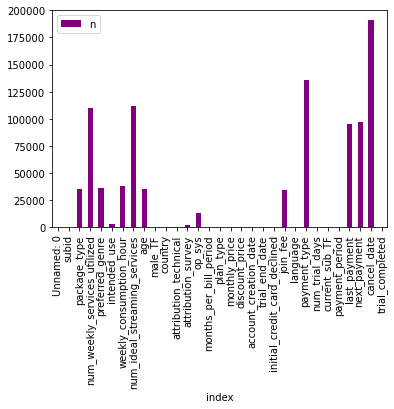

In [10]:
subs.isnull().sum().reset_index(name="n").plot.bar(x='index', y='n', color='purple')

In [11]:
# Keep useful column
df_seg = subs[['subid','weekly_consumption_hour','age','package_type','preferred_genre']]

In [12]:
df_seg.head()

,subid,weekly_consumption_hour,age,package_type,preferred_genre
0,21724479,NaN,NaN,economy,comedy
1,23383224,22.951579,70.0,base,comedy
2,26844789,36.001186,25.0,enhanced,regional
3,29417030,20.051667,30.0,base,drama
4,26723159,22.951579,28.0,base,comedy


In [13]:
df_seg.isnull().sum()

subid                          0
weekly_consumption_hour    37930
age                        35169
package_type               35574
preferred_genre            36326
dtype: int64

## Dealing with Missing Values

In [14]:
# weekly_consumption_hour
df_seg['weekly_consumption_hour'].fillna(value=0.0, inplace = True)

/Users/tianluo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [15]:
df_seg['age'].fillna(value=25.0, inplace = True)

In [16]:
#Age
for i in range(len(df_seg)):
    if len(str(int(df_seg.iloc[i,2]))) == 3:
        df_seg.iloc[i,2] = 99
    elif df_seg.iloc[i,2]>1922 and df_seg.iloc[i,2]<2005:
        df_seg.iloc[i,2] = 2020 - df_seg.iloc[i,2]
    elif len(str(int(df_seg.iloc[i,2]))) >= 4:
        df_seg.iloc[i,2] = 99
    elif df_seg.iloc[i,2] < 12:
        df_seg.iloc[i,2] = 12
    elif df_seg.iloc[i,2]>=2005:
        df_seg.iloc[i,2] = 25

/Users/tianluo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [17]:
# Create Dummy Variables
df_seg['package_type'].fillna(value='other pack',inplace = True)
df_seg['preferred_genre'].fillna(value='other',inplace = True)

df_seg = df_seg.join(pd.get_dummies(df_seg.package_type))
df_seg = df_seg.join(pd.get_dummies(df_seg.preferred_genre))

In [18]:
df_seg['package_type'].value_counts()

base          111464
enhanced       63241
other pack     35574
economy        17349
Name: package_type, dtype: int64

In [19]:
df_seg_input = df_seg.drop(['subid','package_type','preferred_genre'],axis = 1)
df_seg_input.head()

,weekly_consumption_hour,age,base,economy,enhanced,other pack,comedy,drama,international,other,regional
0,0.000000,25.0,0,1,0,0,1,0,0,0,0
1,22.951579,70.0,1,0,0,0,1,0,0,0,0
2,36.001186,25.0,0,0,1,0,0,0,0,0,1
3,20.051667,30.0,1,0,0,0,0,1,0,0,0
4,22.951579,28.0,1,0,0,0,1,0,0,0,0


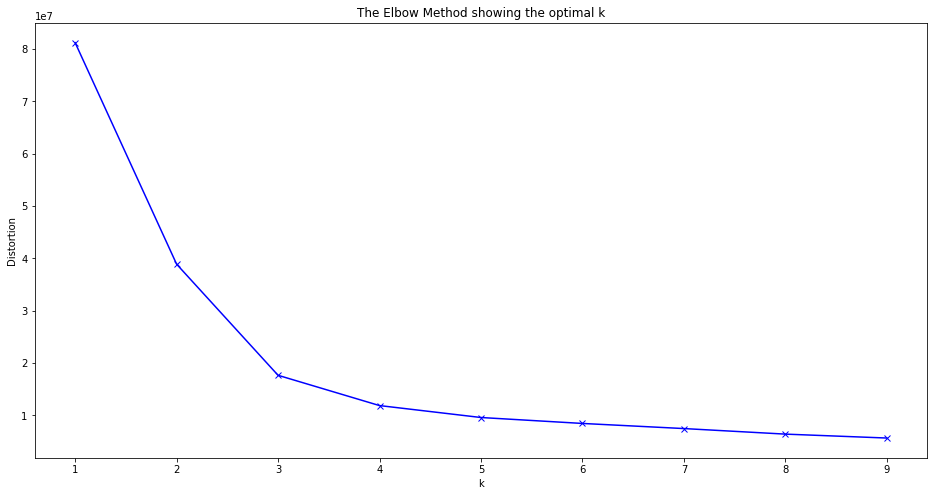

In [20]:
# Elbow Test for customer segmentation
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_seg_input)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [21]:
kmeanModel = KMeans(n_clusters=3)
y_km = kmeanModel.fit_predict(df_seg_input)

In [22]:
clus = pd.DataFrame(y_km)

In [23]:
df_seg_input['cluster'] = clus[0]

In [24]:
clus1 = df_seg_input[df_seg_input['cluster']==0]
clus2 = df_seg_input[df_seg_input['cluster']==1]
clus3 = df_seg_input[df_seg_input['cluster']==2]

In [25]:
clus3

,weekly_consumption_hour,age,base,economy,enhanced,other pack,comedy,drama,international,other,regional,cluster
2,36.001186,25.0,0,0,1,0,0,0,0,0,1,2
3,20.051667,30.0,1,0,0,0,0,1,0,0,0,2
4,22.951579,28.0,1,0,0,0,1,0,0,0,0,2
7,34.551230,23.0,1,0,0,0,0,1,0,0,0,2
11,37.451142,24.0,0,0,1,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
227616,27.301448,44.0,1,0,0,0,0,1,0,0,0,2
227619,30.201361,32.0,1,0,0,0,1,0,0,0,0,2
227622,24.401536,43.0,1,0,0,0,0,1,0,0,0,2
227623,28.751405,38.0,0,0,1,0,1,0,0,0,0,2


<AxesSubplot:xlabel='cluster', ylabel='economy'>

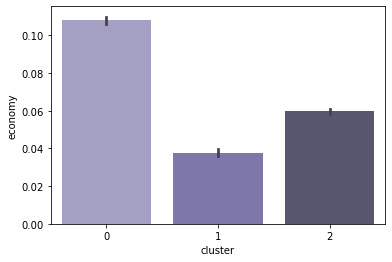

In [26]:
# Cluster Visualization
#sns.barplot(x='cluster',y='weekly_consumption_hour',data=df_seg_input,palette="Purples_d")
#sns.barplot(x='cluster',y='age',data=df_seg_input,palette="Purples_d")
#sns.barplot(x='cluster',y='comedy',data=df_seg_input,palette="Purples_d")
sns.barplot(x='cluster',y='economy',data=df_seg_input,palette="Purples_d")

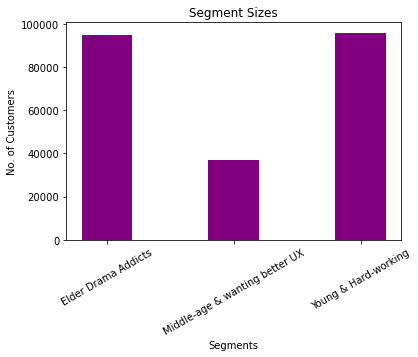

In [27]:
seg_label = ['Elder Drama Addicts','Middle-age & wanting better UX','Young & Hard-working']
seg_size = [clus1.shape[0],clus2.shape[0],clus3.shape[0]]
plt.bar(seg_label, seg_size, color ='purple',
        width = 0.4)
plt.xlabel("Segments")
plt.xticks(rotation=30)
plt.ylabel("No. of Customers")
plt.title("Segment Sizes")
plt.show()

In [28]:
subs['male_TF'].value_counts()

False    200902
True      26457
Name: male_TF, dtype: int64

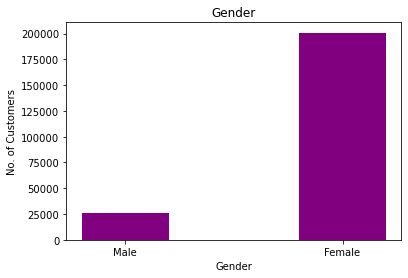

In [29]:
gender = ['Male', 'Female']
num = [26457, 200902]
plt.bar(gender, num, color ='purple',
        width = 0.4)
plt.xlabel("Gender")
plt.ylabel("No. of Customers")
plt.title("Gender")
plt.show()

Text(0, 0.5, 'No. of Customers')

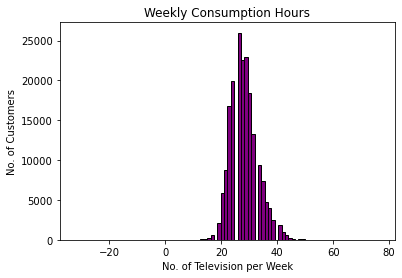

In [30]:
plt.hist(subs['weekly_consumption_hour'], color = 'purple', edgecolor = 'black',
         bins = int(180/2))
plt.title('Weekly Consumption Hours')
plt.xlabel('No. of Television per Week')
plt.ylabel('No. of Customers')

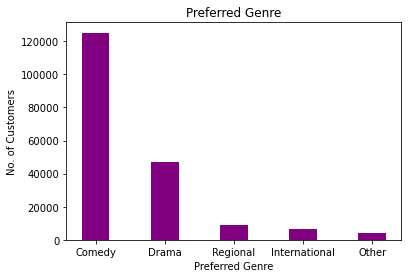

In [31]:
genre = ['Comedy', 'Drama', 'Regional', 'International', "Other"]
num = [125129, 46872, 8990, 6404, 3907]
plt.bar(genre, num, color ='purple',
        width = 0.4)
plt.xlabel("Preferred Genre")
plt.ylabel("No. of Customers")
plt.title("Preferred Genre")
plt.show()

# Attribution and Allocation

<AxesSubplot:>

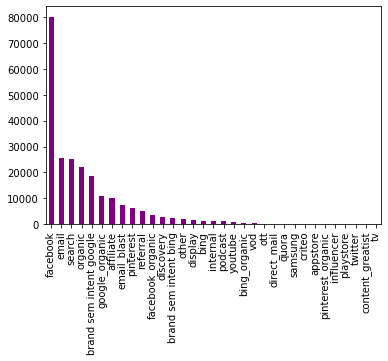

In [32]:
subs['attribution_technical'].value_counts().plot(kind='bar',color='purple')

In [33]:
subs['attribution_technical'].value_counts()

facebook                   80251
email                      25690
search                     25306
organic                    22013
brand sem intent google    18524
google_organic             10691
affiliate                   9894
email_blast                 7277
pinterest                   6065
referral                    5170
facebook_organic            3272
discovery                   2571
brand sem intent bing       2231
other                       1786
display                     1407
bing                        1146
internal                    1122
podcast                      985
youtube                      913
bing_organic                 369
vod                          297
ott                          158
direct_mail                  139
quora                        100
samsung                       86
criteo                        44
appstore                      44
pinterest_organic             30
influencer                    21
playstore                     12
twitter   

In [34]:
cha_sp = {'facebook': 80251,
         'serach': 25306,
         'display': 1407,
         'bing': 1146,
         'youtube': 913}

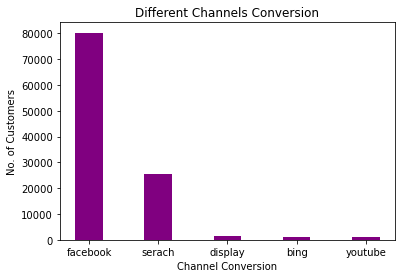

In [35]:
plt.bar(cha_sp.keys(),cha_sp.values(),color='purple',width=0.4)
plt.xlabel("Channel Conversion")
plt.ylabel("No. of Customers")
plt.title("Different Channels Conversion")
plt.show()

In [36]:
spend.head()

,channel,date,spend_AED
0,bing,201907,400
1,display,201907,12
2,facebook,201907,9000
3,search,201907,13000
4,youtube,201907,90


In [37]:
df_attr = subs[['attribution_technical','attribution_survey','account_creation_date']]
df_attr.head()

,attribution_technical,attribution_survey,account_creation_date
0,facebook,facebook,2020-01-24 21:44:16
1,facebook,facebook,2020-03-01 15:44:35
2,organic,facebook,2019-12-07 16:37:06
3,search,tv,2020-01-27 16:09:32
4,discovery,youtube,2019-10-05 12:57:07


## First Interaction

In [38]:
df_attr['attribution_survey'].value_counts()

facebook            119126
tv                   39904
referral             20882
search                8492
pinterest             7856
other                 6496
public_radio          6219
social_organic        3869
youtube               3108
podcast               2995
affiliate             1962
ott                   1443
sirius xm             1122
facebook_organic       765
direct_mail            408
amfm_radio             337
Name: attribution_survey, dtype: int64

In [39]:
df_attr['attribution_survey'].fillna(value='other', inplace = True)

/Users/tianluo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [40]:
df_attr['attribution_survey'].isnull().sum()

0

In [41]:
def date_transform(date):
    newdate = date[0:4]+date[5:7]
    return newdate

In [42]:
df_attr['account_creation_date'] = df_attr['account_creation_date'].map(lambda x: date_transform(str(x)))

<ipython-input-42-c0f7b2601840>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_attr['account_creation_date'] = df_attr['account_creation_date'].map(lambda x: date_transform(str(x)))


In [43]:
#number of customers in each channel
channel_lst = list(spend['channel'].unique())
date_lst = list(spend['date'].unique())
cus_first = {}
for date in date_lst:
    cus_first[str(date)]= {x:0 for x in channel_lst}

for i in df_attr.index:
    if (df_attr.loc[i, 'attribution_survey'] in channel_lst) and (int(df_attr.loc[i, 'account_creation_date']) in date_lst):
        cus_first[df_attr.loc[i,'account_creation_date']][df_attr.loc[i,'attribution_survey']] += 1
        
df_cus_first = pd.DataFrame(cus_first)
df_cus_first

,201907,201908,201909,201910,201911,201912,202001,202002
bing,0,0,0,0,0,0,0,0
display,0,0,0,0,0,0,0,0
facebook,14451,15399,11702,13418,16930,13394,10157,11809
search,536,786,783,853,864,1032,1151,1344
youtube,85,264,209,274,312,245,725,546


In [44]:
#spending in each channel
spend_ = {}
for date in date_lst:
    spend_[str(date)]={x:0 for x in channel_lst}
for i in spend.index:
    spend_[str(spend.loc[i,'date'])][spend.loc[i, 'channel']] = spend.loc[i, 'spend_AED']
    
df_spend = pd.DataFrame(spend_)
df_spend

,201907,201908,201909,201910,201911,201912,202001,202002
bing,400,900,1000,1100,1300,300,2100,3700
display,12,20,13,19,29,31,148,94
facebook,9000,13000,10500,17000,23000,16000,11000,14000
search,13000,18500,19000,24000,25000,38000,41000,44000
youtube,90,180,100,130,550,900,4360,2420


In [45]:
#average CAC calculation
cac_first = df_spend.div(df_cus_first).round(2)
cac_first

,201907,201908,201909,201910,201911,201912,202001,202002
bing,inf,inf,inf,inf,inf,inf,inf,inf
display,inf,inf,inf,inf,inf,inf,inf,inf
facebook,0.62,0.84,0.90,1.27,1.36,1.19,1.08,1.19
search,24.25,23.54,24.27,28.14,28.94,36.82,35.62,32.74
youtube,1.06,0.68,0.48,0.47,1.76,3.67,6.01,4.43


## Last Interaction

In [46]:
#number of customers in each channel
channel_lst = list(spend['channel'].unique())
date_lst = list(spend['date'].unique())
cus_last = {}
for date in date_lst:
    cus_last[str(date)]= {x:0 for x in channel_lst}

for i in df_attr.index:
    if (df_attr.loc[i, 'attribution_technical'] in channel_lst) and (int(df_attr.loc[i, 'account_creation_date']) in date_lst):
        cus_last[df_attr.loc[i,'account_creation_date']][df_attr.loc[i,'attribution_technical']] += 1
        
df_cus_last = pd.DataFrame(cus_last)
df_cus_last

,201907,201908,201909,201910,201911,201912,202001,202002
bing,120,71,84,86,103,28,172,303
display,44,74,12,50,90,112,536,341
facebook,10011,9855,6129,9489,12995,9288,6289,7988
search,1328,1939,1852,2333,2510,3770,4073,4300
youtube,8,15,2,11,47,76,370,205


In [47]:
#average CAC calculation
cac_last = df_spend.div(df_cus_last).round(2)
cac_last

,201907,201908,201909,201910,201911,201912,202001,202002
bing,3.33,12.68,11.90,12.79,12.62,10.71,12.21,12.21
display,0.27,0.27,1.08,0.38,0.32,0.28,0.28,0.28
facebook,0.90,1.32,1.71,1.79,1.77,1.72,1.75,1.75
search,9.79,9.54,10.26,10.29,9.96,10.08,10.07,10.23
youtube,11.25,12.00,50.00,11.82,11.70,11.84,11.78,11.80


# Churn

In [48]:
subs = pd.read_csv('subscribers (1).csv')
subs.drop('Unnamed: 0',axis = 1,inplace = True)
subs.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-24 21:44:16,2020-02-07 21:44:16,False,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,UAE,facebook,facebook,NaN,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-01 15:44:35,2020-03-15 15:44:35,False,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,UAE,organic,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-07 16:37:06,2019-12-21 16:37:06,False,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,UAE,search,tv,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-27 16:09:32,2020-02-10 16:09:32,False,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,UAE,discovery,youtube,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-10-05 12:57:07,2019-10-19 12:57:07,False,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True


In [49]:
subs.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-24 21:44:16,2020-02-07 21:44:16,False,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,UAE,facebook,facebook,NaN,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-01 15:44:35,2020-03-15 15:44:35,False,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,UAE,organic,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-07 16:37:06,2019-12-21 16:37:06,False,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,UAE,search,tv,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-27 16:09:32,2020-02-10 16:09:32,False,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,UAE,discovery,youtube,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-10-05 12:57:07,2019-10-19 12:57:07,False,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True


In [50]:
#drop less useful columns
drop_col_lst = ['subid','country','attribution_survey','op_sys','months_per_bill_period','account_creation_date','trial_end_date','initial_credit_card_declined','payment_type','payment_period','language','last_payment','next_payment','cancel_date']
subs.drop(drop_col_lst,axis = 1,inplace = True)

In [51]:
subs.head()

,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,attribution_technical,plan_type,monthly_price,discount_price,join_fee,num_trial_days,current_sub_TF,trial_completed
0,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,facebook,base_uae_14_day_trial,4.7343,4.5141,NaN,14,True,True
1,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,facebook,base_uae_14_day_trial,4.7343,4.5141,0.3303,14,True,True
2,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,organic,base_uae_14_day_trial,4.7343,4.5141,0.1101,14,False,True
3,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,search,base_uae_14_day_trial,4.7343,4.5141,0.0367,14,False,True
4,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,discovery,base_uae_14_day_trial,4.7343,4.5141,0.0367,14,True,True


In [52]:
#deal with missing values
subs['package_type'].fillna(value = 'other_package',inplace = True)
subs['num_weekly_services_utilized'].fillna(value = 3,inplace = True) # Based on the maxima
subs['preferred_genre'].fillna(value = 'other_genre',inplace = True)
subs['intended_use'].fillna(value = 'other',inplace = True)
subs['weekly_consumption_hour'].fillna(value = 28,inplace = True) # Based on the mean
subs['num_ideal_streaming_services'].fillna(value = 2,inplace = True) # Based on the mean
subs['age'].fillna(value = 25.0,inplace = True)
subs['male_TF'].fillna(value = False,inplace = True) # Based on the maxima
subs['join_fee'].fillna(value = 0.115145,inplace = True) # Based on the mean

In [53]:
#deal with the age
for i in range(len(df_seg)):
    if len(str(int(df_seg.iloc[i,2]))) == 3:
        df_seg.iloc[i,2] = 99
    elif df_seg.iloc[i,2]>1922 and df_seg.iloc[i,2]<2005:
        df_seg.iloc[i,2] = 2020 - df_seg.iloc[i,2]
    elif len(str(int(df_seg.iloc[i,2]))) >= 4:
        df_seg.iloc[i,2] = 99
    elif df_seg.iloc[i,2] < 12:
        df_seg.iloc[i,2] = 12
    elif df_seg.iloc[i,2]>=2005:
        df_seg.iloc[i,2] = 25

In [54]:
subs.head()

,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,attribution_technical,plan_type,monthly_price,discount_price,join_fee,num_trial_days,current_sub_TF,trial_completed
0,economy,3.0,comedy,access to exclusive content,28.000000,2.0,25.0,False,facebook,base_uae_14_day_trial,4.7343,4.5141,0.115145,14,True,True
1,base,3.0,comedy,access to exclusive content,22.951579,2.0,70.0,False,facebook,base_uae_14_day_trial,4.7343,4.5141,0.330300,14,True,True
2,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,organic,base_uae_14_day_trial,4.7343,4.5141,0.110100,14,False,True
3,base,3.0,drama,replace OTT,20.051667,2.0,30.0,False,search,base_uae_14_day_trial,4.7343,4.5141,0.036700,14,False,True
4,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,discovery,base_uae_14_day_trial,4.7343,4.5141,0.036700,14,True,True


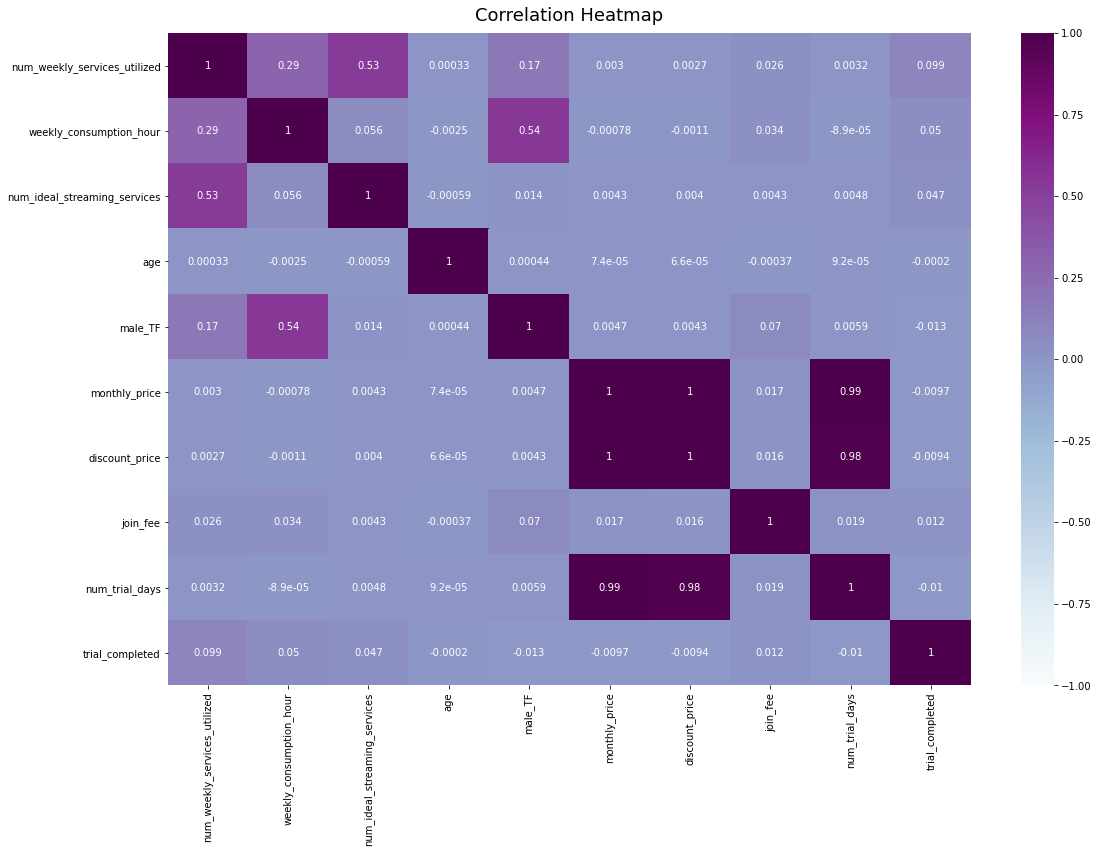

In [55]:
# Correlation Matrix among features
heat = subs.drop('current_sub_TF',axis=1)

fig,ax = plt.subplots(figsize=(18, 12))
heatmap = sns.heatmap(heat.corr(), vmin=-1, vmax=1, annot=True, cmap='BuPu')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);


In [56]:
# Drop highly-correlated columns according to the correlation heatmap
subs.drop(['discount_price', 'num_trial_days', 'num_ideal_streaming_services'],axis=1)
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227628 entries, 0 to 227627
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   package_type                  227628 non-null  object 
 1   num_weekly_services_utilized  227628 non-null  float64
 2   preferred_genre               227628 non-null  object 
 3   intended_use                  227628 non-null  object 
 4   weekly_consumption_hour       227628 non-null  float64
 5   num_ideal_streaming_services  227628 non-null  float64
 6   age                           227628 non-null  float64
 7   male_TF                       227628 non-null  bool   
 8   attribution_technical         227628 non-null  object 
 9   plan_type                     227628 non-null  object 
 10  monthly_price                 227628 non-null  float64
 11  discount_price                227628 non-null  float64
 12  join_fee                      227628 non-nul

In [57]:
# rename elements
subs['package_type'].replace('other','other_genre',inplace = True)
subs['preferred_genre'].replace('other','other_genre',inplace = True)
subs['intended_use'].replace('other','other_intended_use',inplace = True)
subs['attribution_technical'].replace('other','other_attribution_technical',inplace = True)
subs['male_TF'].replace(False,'Female',inplace = True)
subs['male_TF'].replace(True,'Male',inplace = True)
subs['trial_completed'].replace(False,'Incomplete',inplace = True)
subs['trial_completed'].replace(True,'Completed',inplace = True)

In [58]:
subs.head()

,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,attribution_technical,plan_type,monthly_price,discount_price,join_fee,num_trial_days,current_sub_TF,trial_completed
0,economy,3.0,comedy,access to exclusive content,28.000000,2.0,25.0,Female,facebook,base_uae_14_day_trial,4.7343,4.5141,0.115145,14,True,Completed
1,base,3.0,comedy,access to exclusive content,22.951579,2.0,70.0,Female,facebook,base_uae_14_day_trial,4.7343,4.5141,0.330300,14,True,Completed
2,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,Male,organic,base_uae_14_day_trial,4.7343,4.5141,0.110100,14,False,Completed
3,base,3.0,drama,replace OTT,20.051667,2.0,30.0,Female,search,base_uae_14_day_trial,4.7343,4.5141,0.036700,14,False,Completed
4,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,Female,discovery,base_uae_14_day_trial,4.7343,4.5141,0.036700,14,True,Completed


In [59]:
# Get dummies
drop_lst = ['package_type','preferred_genre','intended_use','male_TF','attribution_technical','plan_type','trial_completed']
subs = subs.join(pd.get_dummies(subs.package_type))
subs = subs.join(pd.get_dummies(subs.preferred_genre))
subs = subs.join(pd.get_dummies(subs.intended_use))
subs = subs.join(pd.get_dummies(subs.male_TF))
subs = subs.join(pd.get_dummies(subs.attribution_technical))
subs = subs.join(pd.get_dummies(subs.plan_type))
subs = subs.join(pd.get_dummies(subs.trial_completed))

subs.drop(drop_lst,axis=1,inplace=True)

In [60]:
subs.head()

,num_weekly_services_utilized,weekly_consumption_hour,num_ideal_streaming_services,age,monthly_price,discount_price,join_fee,num_trial_days,current_sub_TF,base,economy,enhanced,other_package,comedy,drama,international,other_genre,regional,access to exclusive content,education,expand international access,expand regional access,other_intended_use,replace OTT,supplement OTT,Female,Male,affiliate,appstore,bing,bing_organic,brand sem intent bing,brand sem intent google,content_greatist,criteo,direct_mail,discovery,display,email,email_blast,facebook,facebook_organic,google_organic,influencer,internal,organic,other_attribution_technical,ott,pinterest,pinterest_organic,playstore,podcast,quora,referral,samsung,search,tv,twitter,vod,youtube,base_eur_14_day_trial,base_uae_14_day_trial,base_uae_no_trial_7_day_guarantee,high_aud_14_day_trial,high_jpy_14_day_trial,high_sar_14_day_trial,high_uae_14_day_trial,low_eur_no_trial,low_gbp_14_day_trial,low_sar_no_trial,low_uae_no_trial,Completed,Incomplete
0,3.0,28.000000,2.0,25.0,4.7343,4.5141,0.115145,14,True,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,3.0,22.951579,2.0,70.0,4.7343,4.5141,0.330300,14,True,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,3.0,36.001186,2.0,25.0,4.7343,4.5141,0.110100,14,False,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,3.0,20.051667,2.0,30.0,4.7343,4.5141,0.036700,14,False,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,4.0,22.951579,3.0,28.0,4.7343,4.5141,0.036700,14,True,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


## Model Building

In [61]:
# DEFINE FUNCTIONS
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_tree'] = (df_f['prob_churn_tree'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_tree'] = (df_f['make_offer_tree'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_tree_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_tree'], 'price_tree_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact
def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives



In [62]:
df_train, df_test = train_test_split(subs,test_size= 0.3)

In [63]:
#standradization
scaler = StandardScaler()
scaler.fit(df_train.drop('current_sub_TF',axis=1))
X_train = scaler.transform(df_train.drop('current_sub_TF',axis=1))

In [64]:
#standradization
scaler.fit(df_test.drop('current_sub_TF',axis=1))
X_test = scaler.transform(df_test.drop('current_sub_TF',axis=1))

In [65]:
y_train = df_train.current_sub_TF
y_test = df_test.current_sub_TF

AUC score:0.5722521411386422


Text(0, 0.5, 'True positives (positive=churn)')

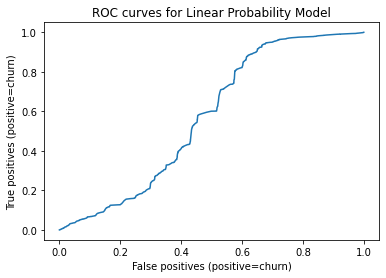

In [66]:
# Linear Probability Model
lpm_model = sm.OLS(endog=y_train, exog=X_train)
lpm = lpm_model.fit()
y_pred_lpm = lpm.predict(X_test)    
fpr_lpm,tpr_lpm,threshold_lpm = metrics.roc_curve(y_test,y_pred_lpm)    
#lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(y_test, y_pred)
auc_lpm = metrics.auc(fpr_lpm,tpr_lpm)     
print("AUC score:{0}".format(auc_lpm))
# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(fpr_lpm, tpr_lpm)
plt.title('ROC curves for Linear Probability Model')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')

Accuracy:0.8367819121674062,AUC score:0.9154507668379008


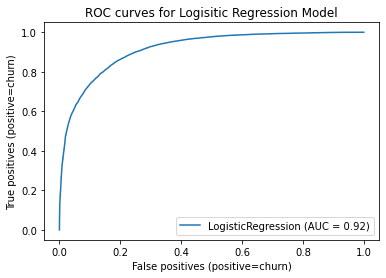

In [67]:
# Logistic Regression Model
lr = LogisticRegression()                                        
lr.fit(X_train,y_train)                                         
y_prob_lr = lr.predict_proba(X_test)[:,1]                           
y_pred_lr = lr.predict(X_test)                                     
fpr_lr,tpr_lr,threshold_lr = metrics.roc_curve(y_test,y_prob_lr)    
auc_lr = metrics.auc(fpr_lr,tpr_lr)                              
score_lr = metrics.accuracy_score(y_test,y_pred_lr)                 
print('Accuracy:{0},AUC score:{1}'.format(score_lr,auc_lr))
metrics.plot_roc_curve(lr, X_test, y_test) 
plt.title('ROC curves for Logisitic Regression Model')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.show()

Accuracy:0.7424328954882924,AUC score:0.7092712927716888


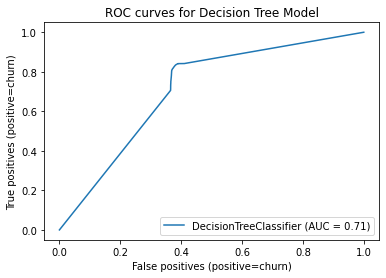

In [68]:
# Decision Tree
tree = tree.DecisionTreeClassifier()                              
tree.fit(X_train,y_train)                                         
y_prob_tree = tree.predict_proba(X_test)[:,1]                          
y_pred_tree = tree.predict(X_test)                                     
fpr_tree,tpr_tree,threshod_tree= metrics.roc_curve(y_test,y_prob_tree)   
score_tree = metrics.accuracy_score(y_test,y_pred_tree)                
auc_tree = metrics.auc(fpr_tree,tpr_tree)

print('Accuracy:{0},AUC score:{1}'.format(score_tree,auc_tree))
metrics.plot_roc_curve(tree, X_test, y_test) 
plt.title('ROC curves for Decision Tree Model')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.show()

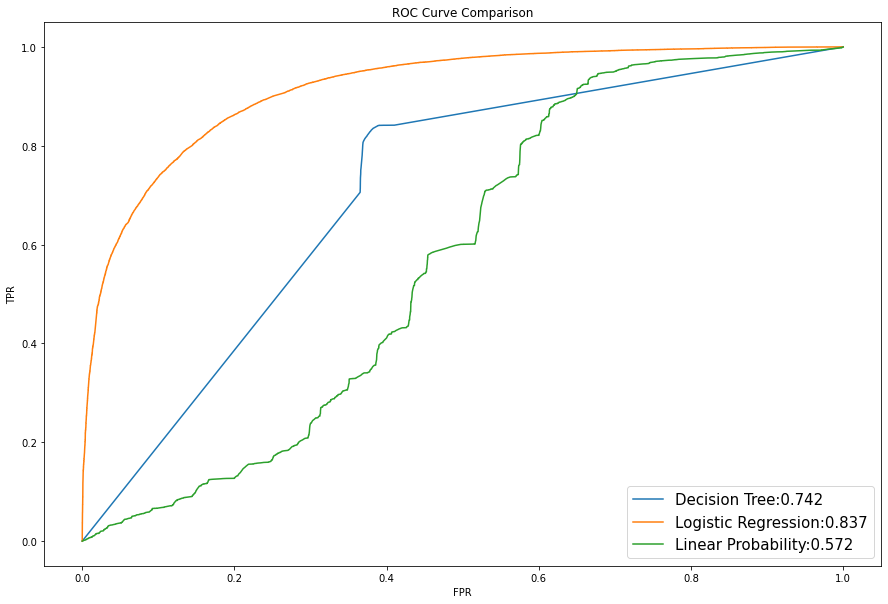

In [69]:
plt.figure(figsize=(15,10))
plt.plot(fpr_tree,tpr_tree,label='Decision Tree:{0:.3f}'.format(score_tree))         
plt.plot(fpr_lr,tpr_lr,label='Logistic Regression:{0:.3f}'.format(score_lr))
plt.plot(fpr_lpm,tpr_lpm,label='Linear Probability:{0:.3f}'.format(auc_lpm))
 
plt.legend(loc='lower right',prop={'size':15})
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Comparison')
plt.show()

# Revenue Lift

In [70]:
# DEFINE FUNCTIONS
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_tree'] = (df_f['prob_churn_tree'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_tree'] = (df_f['make_offer_tree'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_tree_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_tree'], 'price_tree_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact
def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives




In [71]:
df_test['prob_churn_tree'] = y_prob_tree
df_test['prob_churn_logit'] = y_prob_lr

<ipython-input-71-278b523004b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prob_churn_tree'] = y_prob_tree
<ipython-input-71-278b523004b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prob_churn_logit'] = y_prob_lr


In [72]:
df_test.rename(columns={'current_sub_TF':'churn_TF'},inplace = True)

/Users/tianluo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [73]:
df_test['churn_TF'].replace(True,1,inplace = True)
df_test['churn_TF'].replace(False,0,inplace = True)
df_test.head()

/Users/tianluo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,num_weekly_services_utilized,weekly_consumption_hour,num_ideal_streaming_services,age,monthly_price,discount_price,join_fee,num_trial_days,churn_TF,base,economy,enhanced,other_package,comedy,drama,international,other_genre,regional,access to exclusive content,education,expand international access,expand regional access,other_intended_use,replace OTT,supplement OTT,Female,Male,affiliate,appstore,bing,bing_organic,brand sem intent bing,brand sem intent google,content_greatist,criteo,direct_mail,discovery,display,email,email_blast,facebook,facebook_organic,google_organic,influencer,internal,organic,other_attribution_technical,ott,pinterest,pinterest_organic,playstore,podcast,quora,referral,samsung,search,tv,twitter,vod,youtube,base_eur_14_day_trial,base_uae_14_day_trial,base_uae_no_trial_7_day_guarantee,high_aud_14_day_trial,high_jpy_14_day_trial,high_sar_14_day_trial,high_uae_14_day_trial,low_eur_no_trial,low_gbp_14_day_trial,low_sar_no_trial,low_uae_no_trial,Completed,Incomplete,prob_churn_tree,prob_churn_logit
147883,3.0,22.951579,2.0,34.0,4.7343,4.5141,0.036700,14,1.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.0,0.882142
205437,3.0,28.000000,2.0,25.0,4.7343,4.5141,0.115145,14,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.0,0.944651
208302,2.0,22.951579,2.0,75.0,4.7343,4.5141,0.036700,14,0.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.0,0.698827
136162,3.0,24.401536,2.0,40.0,4.7343,4.5141,0.330300,14,1.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.0,0.903012
22681,3.0,24.401536,2.0,67.0,4.7343,4.5141,0.000000,14,0.0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.0,0.759635


In [74]:
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 10
discount_amount = 0.3
cases = ['no_offer', 'tree_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)


# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind



<ipython-input-74-0d9c8c2d678c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['random_draws'] = np.random.random(df_test.shape[0])


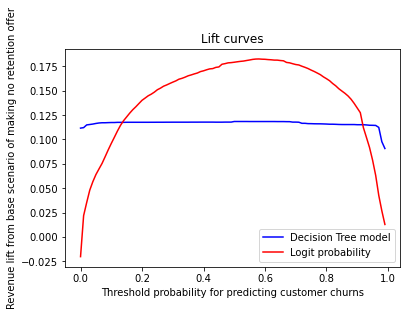

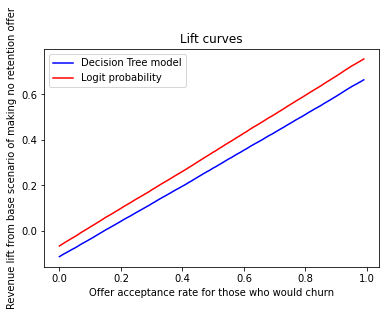

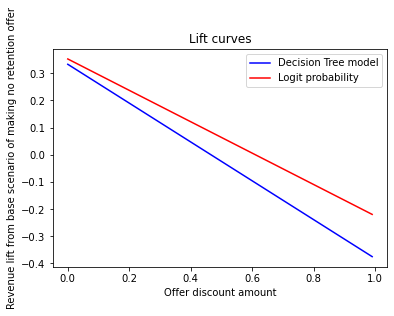

In [75]:
# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['tree_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Decision Tree model', 'Logit probability'])

# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['tree_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Decision Tree model', 'Logit probability'])

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['tree_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Decision Tree model', 'Logit probability'])
